<a href="https://colab.research.google.com/github/alexandergribenchenko/DS_LATAM_Test/blob/main/Model_Explorarions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **¿Nuevo o Usado?**
**Test - Data Scientist - Mercado libre (Presentado por: Alexander Ortega, Mayo 2022)**
 
Este notebook presenta la solución a un reto analitico de clasificación de artículos nuevos o usados en el contexto del Marketplace de Mercado Libre.
 
El notebook está compuesto de 2 secciones que tienen como alcances principales los siguientes objetivos:
 
- **A. Preparación del dataset para consumo del modelo:** En esta sección se presenta la ingesta, procesamiento de datos, atributos, criterios analíticos para la selección de variables, y preparación del dataset base para generar el modelo de clasificación.
- **B. Implementación y evaluación del modelo de clasificación:** se presenta la implementación del modelo junto con la discusión sobre las métricas y los criterios analíticos empleados en su selección.

**Nota introductoria para la ejecución del notebook:** El presente notebook fue desarrollado empleando Google Colab y se recomienda, con el fin de obtener una correcta visualización de la totalidad de las gráficas y salidas del notebook, que este sea ejecutado de principio a fin en dicho entorno. Es posible que algunas gráficas interactivas que el paquete PyCaret genera que no se pueden visualizar en la vista previa del notebook desplegada en el repositorio de github, y que se sólo pueden verse al generar su ejecución.

# **A. Preparación del dataset para consumo del modelo**

## 01. Conexión al repositorio donde tenemos nuestra data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 02. Librerías necesarias para la sección A

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import json
import warnings
warnings.filterwarnings("ignore")

## 03. Lectura de la data raw suministrada para el proyecto

In [ ]:
path = '/content/drive/MyDrive/01_Code/00_Test_MELI_Alexander/'
file_name = 'MLA_100k.jsonlines'

In [ ]:
# Función de lectura suministrada como parte del proyecto
def build_dataset():
    data = [json.loads(x) for x in open(path + file_name)]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [ ]:
# Data de entrenamiento y validación
X_train, y_train, X_test, y_test = build_dataset()

In [ ]:
# Corroboramos el tipo de data obtenida
type(X_train)

list

In [ ]:
type(X_train[0])

dict

In [ ]:
# Evaluamos una muestra para corroborar la estructura de los registros.
# Se observa que los registros presentan informacion anidada a manera de diccionario.
# Por tal motivo al hacer la carga de la misma emplearemos la función json_normalize()
X_train[0]

{'accepts_mercadopago': True,
 'attributes': [],
 'automatic_relist': False,
 'available_quantity': 1,
 'base_price': 80,
 'buying_mode': 'buy_it_now',
 'catalog_product_id': None,
 'category_id': 'MLA126406',
 'condition': 'new',
 'coverage_areas': [],
 'currency_id': 'ARS',
 'date_created': '2015-09-05T20:42:53.000Z',
 'deal_ids': [],
 'descriptions': [{'id': 'MLA578052519-912855983'}],
 'differential_pricing': None,
 'geolocation': {'latitude': -34.6280698, 'longitude': -58.3986709},
 'id': 'MLA578052519',
 'initial_quantity': 1,
 'international_delivery_mode': 'none',
 'last_updated': '2015-09-05T20:42:58.000Z',
 'listing_source': '',
 'listing_type_id': 'bronze',
 'location': {},
 'non_mercado_pago_payment_methods': [{'description': 'Transferencia bancaria',
   'id': 'MLATB',
   'type': 'G'},
  {'description': 'Acordar con el comprador', 'id': 'MLAWC', 'type': 'G'},
  {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}],
 'official_store_id': None,
 'original_price': None,
 'p

In [ ]:
# Evaluamos así mismo el target
y_train[:10]

['new', 'used', 'used', 'new', 'used', 'new', 'used', 'used', 'new', 'new']

In [ ]:
# Realizamos la carga y la exploración de los features del dataset.
# Podemos observar que las columnas que presentaban inicialmente información
# anidada a manera de diccionario aparecen ahora desagregadas hasta su ultimo nivel
df_X_train_raw = pd.json_normalize(X_train)
df_X_test_raw = pd.json_normalize(X_test)
df_X_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 92 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   warranty                                          35243 non-null  object 
 1   sub_status                                        90000 non-null  object 
 2   condition                                         90000 non-null  object 
 3   seller_contact                                    0 non-null      float64
 4   deal_ids                                          90000 non-null  object 
 5   base_price                                        90000 non-null  float64
 6   non_mercado_pago_payment_methods                  90000 non-null  object 
 7   seller_id                                         90000 non-null  int64  
 8   variations                                        90000 non-null  object 
 9   site_id          

## 04. Preprocesamiento de la data 

### 04.01. Criterio inicial para selección de features (features con valores nulos <10%)

Con el fin de simplificar el conjunto de datos, trabajaremos inicialmente de manera única con los features que presenten como máximo un 10% de valores nulos. Si bien el criterio es arbitrario pues podría hacerse una análisis de valores nulos y estudiar sus motivos y alternativas de imputación, este es un criterio útil en una primera exploración.

Así, de los 92 features obtenemos inicialmente 60 para trabajar.


In [ ]:
# Filtrado de los features a partir del umbral de corte
# (La matriz permite visualizar los features que cumplen el criterio)
Porcentaje_corte = 10
df_aux_nulls = df_X_train_raw.isnull().sum().to_frame().reset_index()
df_aux_nulls.columns = ['feature','N_nulls']
df_aux_nulls['Perc_nulls'] = round(100*(df_aux_nulls['N_nulls']/len(df_X_train_raw)),2)
df_aux_nulls = df_aux_nulls[df_aux_nulls.Perc_nulls<Porcentaje_corte].reset_index(drop=True)
df_aux_nulls

,feature,N_nulls,Perc_nulls
0,sub_status,0,0.00
1,condition,0,0.00
2,deal_ids,0,0.00
3,base_price,0,0.00
4,non_mercado_pago_payment_methods,0,0.00
5,seller_id,0,0.00
6,variations,0,0.00
7,site_id,0,0.00
8,listing_type_id,0,0.00
9,price,0,0.00


In [ ]:
# Lista de features que cumplen con el criterio
list_col_prefiltered = list(df_aux_nulls.feature)
list_col_prefiltered

['sub_status',
 'condition',
 'deal_ids',
 'base_price',
 'non_mercado_pago_payment_methods',
 'seller_id',
 'variations',
 'site_id',
 'listing_type_id',
 'price',
 'attributes',
 'buying_mode',
 'tags',
 'listing_source',
 'coverage_areas',
 'category_id',
 'descriptions',
 'last_updated',
 'international_delivery_mode',
 'pictures',
 'id',
 'accepts_mercadopago',
 'currency_id',
 'thumbnail',
 'title',
 'automatic_relist',
 'date_created',
 'secure_thumbnail',
 'stop_time',
 'status',
 'initial_quantity',
 'start_time',
 'permalink',
 'sold_quantity',
 'available_quantity',
 'seller_address.comment',
 'seller_address.longitude',
 'seller_address.id',
 'seller_address.country.name',
 'seller_address.country.id',
 'seller_address.address_line',
 'seller_address.latitude',
 'seller_address.search_location.neighborhood.name',
 'seller_address.search_location.neighborhood.id',
 'seller_address.search_location.state.name',
 'seller_address.search_location.state.id',
 'seller_address.searc

In [ ]:
# Cantidad de features que cumplen con el criterio
len(list_col_prefiltered)

60

In [ ]:
# Generamos el dataset filtrado sobre el que generaremos todo el preprocesamiento:
df_X_train = df_X_train_raw[list_col_prefiltered]
df_X_test = df_X_test_raw[set(list_col_prefiltered)-set(['condition'])]
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 60 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   sub_status                                        90000 non-null  object 
 1   condition                                         90000 non-null  object 
 2   deal_ids                                          90000 non-null  object 
 3   base_price                                        90000 non-null  float64
 4   non_mercado_pago_payment_methods                  90000 non-null  object 
 5   seller_id                                         90000 non-null  int64  
 6   variations                                        90000 non-null  object 
 7   site_id                                           90000 non-null  object 
 8   listing_type_id                                   90000 non-null  object 
 9   price            

### 04.02. Visualización del type de los features con que cuenta el dataset

A partir de la información general del dataset observamos que cuenta con features con 4 types diferentes:  bool(4), float64(2), int64(4), object(50). Es necesario explorarlos con mayor detalle pues existe información que aún está anidada en algunos de ellos, así como también es necesario hacer una reasignación de types en caso de que no presenten correspondencia.
 
Trabajaremos así entonces de manera independiente sobre cada uno de los tipos de features para su procesamiento.

In [ ]:
# Generamos una visualización general del dataset
df_X_train.head(3)

,sub_status,condition,deal_ids,base_price,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,accepts_mercadopago,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,initial_quantity,start_time,permalink,sold_quantity,available_quantity,seller_address.comment,seller_address.longitude,seller_address.id,seller_address.country.name,seller_address.country.id,seller_address.address_line,seller_address.latitude,seller_address.search_location.neighborhood.name,seller_address.search_location.neighborhood.id,seller_address.search_location.state.name,seller_address.search_location.state.id,seller_address.search_location.city.name,seller_address.search_location.city.id,seller_address.zip_code,seller_address.city.name,seller_address.city.id,seller_address.state.name,seller_address.state.id,shipping.local_pick_up,shipping.methods,shipping.tags,shipping.free_shipping,shipping.mode,geolocation.latitude,geolocation.longitude
0,[],new,[],80.0,"[{'description': 'Transferencia bancaria', 'id...",74952096,[],MLA,bronze,80.0,[],buy_it_now,[dragged_bids_and_visits],,[],MLA126406,[{'id': 'MLA578052519-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'size': '500x375', 'secure_url': 'https://a2...",MLA578052519,True,ARS,http://mla-s1-p.mlstatic.com/5386-MLA435206787...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-04T20:42:53.000Z,active,1,2015-09-05T20:42:53.000Z,http://articulo.mercadolibre.com.ar/MLA-578052...,0,1,,-58.398671,78162842,Argentina,AR,,-34.62807,San Cristóbal,TUxBQlNBTjkwNTZa,Capital Federal,TUxBUENBUGw3M2E1,Capital Federal,TUxBQ0NBUGZlZG1sYQ,,San Cristóbal,TUxBQlNBTjkwNTZa,Capital Federal,AR-C,True,[],[],False,not_specified,-34.62807,-58.398671
1,[],used,[],2650.0,"[{'description': 'Transferencia bancaria', 'id...",42093335,[],MLA,silver,2650.0,[],buy_it_now,[],,[],MLA10267,[{'id': 'MLA581565358-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'size': '499x334', 'secure_url': 'https://a2...",MLA581565358,True,ARS,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-25T18:08:30.000Z,active,1,2015-09-26T18:08:30.000Z,http://articulo.mercadolibre.com.ar/MLA-581565...,0,1,,-58.505917,105272448,Argentina,AR,,-34.593552,Villa Devoto,TUxBQlZJTDYzNzZa,Capital Federal,TUxBUENBUGw3M2E1,Capital Federal,TUxBQ0NBUGZlZG1sYQ,,Buenos Aires,,Capital Federal,AR-C,True,[],[],False,me2,-34.593552,-58.505917
2,[],used,[],60.0,"[{'description': 'Transferencia bancaria', 'id...",133384258,[],MLA,bronze,60.0,[],buy_it_now,[dragged_bids_and_visits],,[],MLA1227,[{'id': 'MLA578780872-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA578780872,True,ARS,http://mla-s1-p.mlstatic.com/22076-MLA20223367...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-08T23:57:07.000Z,active,1,2015-09-09T23:57:07.000Z,http://articulo.mercadolibre.com.ar/MLA-578780...,0,1,,-58.414395,103489016,Argentina,AR,,-34.623391,Boedo,TUxBQkJPRTQ0OTRa,Capital Federal,TUxBUENBUGw3M2E1,Capital Federal,TUxBQ0NBUGZlZG1sYQ,,Boedo,TUxBQkJPRTQ0OTRa,Capital Federal,AR-C,True,[],[],False,me2,-34.623391,-58.414395


#### 04.02.01. Visualización features con type bool

In [ ]:
list_col_type_bool = df_X_train.select_dtypes('bool').columns.to_list()
list_col_type_bool

['accepts_mercadopago',
 'automatic_relist',
 'shipping.local_pick_up',
 'shipping.free_shipping']

#### 04.02.02. Visualización features con type int

In [ ]:
list_col_type_int = df_X_train.select_dtypes('int').columns.to_list()
list_col_type_int

['seller_id', 'initial_quantity', 'sold_quantity', 'available_quantity']

#### 04.02.03. Visualización features con type float

In [ ]:
list_col_type_float = df_X_train.select_dtypes(['float','float32','float64']).columns.to_list()
list_col_type_float

['base_price', 'price']

#### 04.02.04. Visualización features con type object

Encontramos que los features con type object estan constituidos por 4 tipos con la siguientes distribuciones: 
<class 'str'>      34
<class 'list'>     11
<class 'float'>     4
<class 'int'>       1

Trabajaremos de manera independiente con cada uno de ellos, generando el procesamiento adecuado para cada uno de ellos.

In [ ]:
# Listado con el feature y el subtipo de clase a las que pertenecen los objetos
list_col_type_object = df_X_train.select_dtypes('object').columns.to_list()
list_col_type_object_subtype = [type(df_X_train[x][0]) for x in list_col_type_object]

In [ ]:
# Matriz auxiliar que muestra el tipo de clase al que pertenecen
df_aux_types = pd.DataFrame(list(zip(list_col_type_object, list_col_type_object_subtype)),columns =['feature_name', 'feature_type'])
df_aux_types

,feature_name,feature_type
0,sub_status,<class 'list'>
1,condition,<class 'str'>
2,deal_ids,<class 'list'>
3,non_mercado_pago_payment_methods,<class 'list'>
4,variations,<class 'list'>
5,site_id,<class 'str'>
6,listing_type_id,<class 'str'>
7,attributes,<class 'list'>
8,buying_mode,<class 'str'>
9,tags,<class 'list'>


In [ ]:
df_aux_types.feature_type.value_counts()

<class 'str'>      34
<class 'list'>     11
<class 'float'>     4
<class 'int'>       1
Name: feature_type, dtype: int64

##### **---> Visualización features: type object - subtipo int**

In [ ]:
# Obtenemos el listado de features que cumplen con el criterio para agregarlo posteriormente a las variables tipo int
list_col_type_object_subtype_int = list(df_aux_types[df_aux_types.feature_type==int].feature_name)
list_col_type_object_subtype_int

['seller_address.id']

##### **---> Visualización features: type object - subtipo float**

In [ ]:
# Obtenemos el listado de features que cumplen con el criterio para agregarlo posteriormente a las variables tipo float
list_col_type_object_subtype_float = list(df_aux_types[df_aux_types.feature_type==float].feature_name)
list_col_type_object_subtype_float

['seller_address.longitude',
 'seller_address.latitude',
 'geolocation.latitude',
 'geolocation.longitude']

##### **---> Visualización features: type object - subtipo str**

In [ ]:
# Obtenemos el listado de features que cumplen con el criterio
list_col_type_object_subtype_str = list(df_aux_types[df_aux_types.feature_type==str].feature_name)
list_col_type_object_subtype_str

['condition',
 'site_id',
 'listing_type_id',
 'buying_mode',
 'listing_source',
 'category_id',
 'last_updated',
 'international_delivery_mode',
 'id',
 'currency_id',
 'thumbnail',
 'title',
 'date_created',
 'secure_thumbnail',
 'stop_time',
 'status',
 'start_time',
 'permalink',
 'seller_address.comment',
 'seller_address.country.name',
 'seller_address.country.id',
 'seller_address.address_line',
 'seller_address.search_location.neighborhood.name',
 'seller_address.search_location.neighborhood.id',
 'seller_address.search_location.state.name',
 'seller_address.search_location.state.id',
 'seller_address.search_location.city.name',
 'seller_address.search_location.city.id',
 'seller_address.zip_code',
 'seller_address.city.name',
 'seller_address.city.id',
 'seller_address.state.name',
 'seller_address.state.id',
 'shipping.mode']

**Nota:** Por una limitación en la visualización interactiva no se incluye en la presente sección del notebook una visualización generada por el paquete Pandas Profiling, que me ayudó a complementar los criterios de selección tras el EDA realizado. Sin embargo abajo aparecen impresos las composiciones y distribuciones de las variables evaluadas.

In [ ]:
for i in list_col_type_object_subtype_str:
  print('')
  print('----------------------------------------')
  print(df_X_train[i].value_counts(dropna=False))
  print('----------------------------------------')


----------------------------------------
new     48352
used    41648
Name: condition, dtype: int64
----------------------------------------

----------------------------------------
MLA    90000
Name: site_id, dtype: int64
----------------------------------------

----------------------------------------
bronze          56904
free            19260
silver           8195
gold_special     2693
gold             2170
gold_premium      765
gold_pro           13
Name: listing_type_id, dtype: int64
----------------------------------------

----------------------------------------
buy_it_now    87311
classified     1982
auction         707
Name: buying_mode, dtype: int64
----------------------------------------

----------------------------------------
    90000
Name: listing_source, dtype: int64
----------------------------------------

----------------------------------------
MLA1227      4139
MLA2044      1759
MLA41287      829
MLA3530       685
MLA2038       601
             ... 
MLA376520

Generando una revisión seleccionamos y descartamos features de acuerdo a los siguientes criterios:
 
**Elementos descartados (del total):**
- **condition:** corresponde de manera idéntica con el target que se desea predecir.
- **site_id, international_delivery_mode:** features con  registros idénticos para todas los registros.
- **seller_address.comment, seller_address.address_line, seller_address.zip_code:** nulo para casi la totalidad de valores
 
 
 
**Elementos descartados (con posible tratamiento pero que no se abordarán en este proyecto por tiempo y alcance):**
- **last_updated, date_created, stop_time, start_time:** Elementos tipo timestamp. Si bien puede hacerse una conversión y agregar día, mes año y demás variables como criterio inicialmente las descartamos.
- **thumbnail, secure_thumbnail:** Aunque se descartan se puede implementar AI Vision para hacer más robusta la clasificación empleando la información de las imágenes en los enlaces.
- **title, permalink:** Aunque se descartan se puede implementar NLP para hacer más robusta la clasificación basada en texto.
- **id, category_id, seller_address.search_location.state.name, seller_address.search_location.state.name, seller_address.city.name, seller_address.state.name, seller_address.country.name, seller_address.country.id:** elementos categóricos con alta cardinalidad. Dado que debe hacerse one hot encoding debemos descartarlos. Algunos de ellos como barrios, ciudades podrían reagruparse reduciendo su cardinalidad.
 
 
**Elementos seleccionados:**
- **listing_type_id, buying_mode, currency_id, status, shipping.mode** elementos categóricos con baja cardinalidad que pueden tentativamente aportar al algoritmo de clasificación.

In [ ]:
list_col_type_object_subtype_str_selected = ['listing_type_id', 'buying_mode', 'currency_id', 'status', 'shipping.mode']

##### **---> Visualización features: type object - subtipo list**

Sobre este conjunto de variables debe hacerse un proceso diferenciado dado que presentan información anidada y con estructuras diferentes. En algunos casos son listas simples, en otros son listas con diccionarios únicos, en otras listas con conjuntos de diccionarios. 
 
Estas transformaciones se pueden abordar para cada una de las columnas implementando funciones mapapply de pandas en conjunto con funciones lambda en relación con la estructura propia de cada feature. Adicionalmente se pueden generar características adicionales como por ejemplo la cantidad de imágenes por publicación, creando así features complementarias.
 
Sin embargo esta aproximación se deja propuesta únicamente por temas de tiempo y la única desagregación que se generó es la propia desagregación que la función de normalización que el paquete de json tiene incluida.


In [ ]:
# Obtenemos el listado de features que cumplen con el criterio 
list_col_type_object_subtype_list = list(df_aux_types[df_aux_types.feature_type==list].feature_name)
list_col_type_object_subtype_list

['sub_status',
 'deal_ids',
 'non_mercado_pago_payment_methods',
 'variations',
 'attributes',
 'tags',
 'coverage_areas',
 'descriptions',
 'pictures',
 'shipping.methods',
 'shipping.tags']

In [ ]:
df_X_train[list_col_type_object_subtype_list].head(2)

,sub_status,deal_ids,non_mercado_pago_payment_methods,variations,attributes,tags,coverage_areas,descriptions,pictures,shipping.methods,shipping.tags
0,[],[],"[{'description': 'Transferencia bancaria', 'id...",[],[],[dragged_bids_and_visits],[],[{'id': 'MLA578052519-912855983'}],"[{'size': '500x375', 'secure_url': 'https://a2...",[],[]
1,[],[],"[{'description': 'Transferencia bancaria', 'id...",[],[],[],[],[{'id': 'MLA581565358-930764806'}],"[{'size': '499x334', 'secure_url': 'https://a2...",[],[]


## 05. Creación del dataset de entrenamiento depurado

### 05.01. Reasignación de types

##### ---> Features tipo bool (totalidad):

In [ ]:
list_col_type_bool

['accepts_mercadopago',
 'automatic_relist',
 'shipping.local_pick_up',
 'shipping.free_shipping']

In [ ]:
for i in list_col_type_bool:
  df_X_train[i]=df_X_train[i].astype('bool')
  df_X_test[i]=df_X_test[i].astype('bool')

##### ---> Features tipo int (totalidad):

In [ ]:
list_col_type_int

['seller_id', 'initial_quantity', 'sold_quantity', 'available_quantity']

In [ ]:
list_col_type_int_total = list(set(list_col_type_int)-set(['seller_id']))
list_col_type_int_total

['initial_quantity', 'available_quantity', 'sold_quantity']

In [ ]:
for i in list_col_type_int_total:
  df_X_train[i]=df_X_train[i].astype('int')
  df_X_test[i]=df_X_test[i].astype('int')

##### ---> Features tipo float (totalidad):

In [ ]:
# Obtenemos la totalidad de los features tipo float 
list_col_type_float_total = list_col_type_float + list_col_type_object_subtype_float
list_col_type_float_total

['base_price',
 'price',
 'seller_address.longitude',
 'seller_address.latitude',
 'geolocation.latitude',
 'geolocation.longitude']

In [ ]:
# Reasignación de las variables tipo float dentro del  dataframe general
for i in list_col_type_float_total:
  df_X_train[i]= pd.to_numeric(df_X_train[i], downcast="float")
  df_X_test[i]= pd.to_numeric(df_X_test[i], downcast="float")

##### ---> Features tipo categorical (totalidad):

In [ ]:
# Listamos las variables de tipo str categorico que habíamos seleccionado bajo criterio
list_col_type_category = ['listing_type_id', 'buying_mode', 'currency_id', 'status']

In [ ]:
# Reasignación de las variables tipo float dentro del dataframe general
for i in list_col_type_category:
  df_X_train[i]=df_X_train[i].astype('category')
  df_X_test[i]=df_X_test[i].astype('category')

### 05.02. Dataset de salida para modelado

In [ ]:
# Agrupamos la totalidad de las varibles para obtener el dataset a ser empleado en el modelado
list_col_tot_selected = list_col_type_bool+\
                        list_col_type_int_total+\
                        list_col_type_float_total+\
                        list_col_type_category
list_col_tot_selected

['accepts_mercadopago',
 'automatic_relist',
 'shipping.local_pick_up',
 'shipping.free_shipping',
 'initial_quantity',
 'available_quantity',
 'sold_quantity',
 'base_price',
 'price',
 'seller_address.longitude',
 'seller_address.latitude',
 'geolocation.latitude',
 'geolocation.longitude',
 'listing_type_id',
 'buying_mode',
 'currency_id',
 'status']

In [ ]:
df_X_train_curated = df_X_train[list_col_tot_selected]
df_X_test_curated = df_X_test[list_col_tot_selected]

In [ ]:
# Dado que el paquete de AutoML (Pycaret) que utilizaremos debe contar con la variable
# target dentro del propio dataset, la incluiremos a continuación:

# El etiquetado usado es muy importante y el criterio será descrito en la sección de 
# evaluación de métricas
transformation = {'used': True, 'new': False}

df_X_train_curated['target']=y_train
df_X_train_curated['target']=df_X_train_curated['target'].map(transformation)
df_X_train_curated['target']=df_X_train_curated['target'].astype('bool')

df_X_test_curated['target']=y_test
df_X_test_curated['target']=df_X_test_curated['target'].map(transformation)
df_X_test_curated['target']=df_X_test_curated['target'].astype('bool')

In [ ]:
df_X_train_curated

,accepts_mercadopago,automatic_relist,shipping.local_pick_up,shipping.free_shipping,initial_quantity,available_quantity,sold_quantity,base_price,price,seller_address.longitude,seller_address.latitude,geolocation.latitude,geolocation.longitude,listing_type_id,buying_mode,currency_id,status,target
0,True,False,True,False,1,1,0,80.000000,80.000000,-58.398670,-34.628071,-34.628071,-58.398670,bronze,buy_it_now,ARS,active,False
1,True,False,True,False,1,1,0,2650.000000,2650.000000,-58.505917,-34.593552,-34.593552,-58.505917,silver,buy_it_now,ARS,active,True
2,True,False,True,False,1,1,0,60.000000,60.000000,-58.414394,-34.623390,-34.623390,-58.414394,bronze,buy_it_now,ARS,active,True
3,True,False,True,False,1,1,0,580.000000,580.000000,-58.492920,-34.628189,-34.628189,-58.492920,silver,buy_it_now,ARS,active,False
4,True,False,True,False,1,1,0,30.000000,30.000000,-58.549503,-34.634655,-34.634655,-58.549503,bronze,buy_it_now,ARS,active,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,True,False,False,False,1,1,0,68.000000,68.000000,-58.512207,-34.606106,-34.606106,-58.512207,bronze,buy_it_now,ARS,active,True
89996,True,False,True,False,1,1,1,126.000000,126.000000,-58.381592,-34.603722,-34.603722,-58.381592,bronze,buy_it_now,ARS,paused,False
89997,True,False,True,False,1,1,0,300.000000,300.000000,-58.589928,-34.696419,-34.696419,-58.589928,bronze,buy_it_now,ARS,active,False
89998,True,False,False,False,100,100,0,696.580017,696.580017,-65.312828,-43.254898,-43.254898,-65.312828,bronze,buy_it_now,ARS,active,False


In [ ]:
df_X_test_curated

,accepts_mercadopago,automatic_relist,shipping.local_pick_up,shipping.free_shipping,initial_quantity,available_quantity,sold_quantity,base_price,price,seller_address.longitude,seller_address.latitude,geolocation.latitude,geolocation.longitude,listing_type_id,buying_mode,currency_id,status,target
0,True,False,True,False,1,1,0,6700.0,6700.0,-58.948750,-34.610683,-34.610683,-58.948750,silver,buy_it_now,ARS,active,True
1,True,False,False,False,19,19,0,119.0,119.0,-58.381592,-34.603722,-34.603722,-58.381592,bronze,buy_it_now,ARS,active,False
2,True,False,False,False,2,2,0,450.0,450.0,-58.631729,-34.692066,-34.692066,-58.631729,bronze,buy_it_now,ARS,active,False
3,True,False,True,False,1,1,0,40.0,40.0,-58.510281,-34.484993,-34.484993,-58.510281,bronze,buy_it_now,ARS,active,True
4,True,False,True,False,1,1,1,30.0,30.0,-58.425423,-34.582630,-34.582630,-58.425423,bronze,buy_it_now,ARS,active,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,False,True,False,1,1,0,30.0,30.0,-58.614288,-34.489319,-34.489319,-58.614288,free,buy_it_now,ARS,active,True
9996,True,False,False,False,5,5,0,239.0,239.0,NaN,NaN,NaN,NaN,bronze,buy_it_now,ARS,active,False
9997,True,False,False,False,1,1,0,600.0,600.0,-58.624119,-34.646786,-34.646786,-58.624119,bronze,buy_it_now,ARS,active,True
9998,True,False,True,False,1,1,0,50.0,50.0,-58.402039,-34.610008,-34.610008,-58.402039,bronze,buy_it_now,ARS,active,True


##### **---> Almacenamiento del los datasets curados para el modelado:**
Con el fin de poder tener ejecuciones parciales del notebook en caso de que se presenten fallos o que se quiera ejecutar de manera modular, se almacenan en la presente sección los datasets ya curados a ser usados en el entrenamiento y evaluación del modelo.

In [ ]:
path = '/content/drive/MyDrive/01_Code/00_Test_MELI_Alexander/'
file_output_train_name = 'df_X_train_curated.pkl'
file_output_test_name = 'df_X_test_curated.pkl'

In [ ]:
df_X_train_curated.to_pickle(path + file_output_train_name)
df_X_test_curated.to_pickle(path + file_output_test_name)

# **B. Implementación y evaluación del modelo de clasificación:**

## 01. Conexión al repositorio donde tenemos nuestra data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 02. Librerías necesarias para la sección de modelación (Pycaret: recurso de Auto ML)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Para implementar el modelo emplearemos la herramienta de AutoML Pycaret. La documentación en pleno del recurso empleado enfocado en problemas de clasificación [es este](https://pycaret.readthedocs.io/en/latest/api/classification.html). Paso a paso iremos describiendo la parametrización que se emplea para el actual problema. 

Dado que Pycaret emplea 'por detrás' herramientas y modelos de Scikit-Learn, es posible en caso de ser deseado llevar y replicar los modelos una vez se obtengan el mejor experimento. En este caso nuestro foco será encontrar  encontrar el modelo y la métrica adecuada para el problema descrito.

In [ ]:
!pip install pycaret
!pip install markupsafe==2.0.1

import pycaret
from pycaret.utils import enable_colab
enable_colab()

In [ ]:
# Cargamos la totalidad de recursos con que cuenta pycaret para problemas de clasificación
from pycaret.classification import *

## 03. Carga de los dataframes ya curados para el modelado

In [ ]:
path = '/content/drive/MyDrive/01_Code/00_Test_MELI_Alexander/'
file_output_train_name = 'df_X_train_curated.pkl'
file_output_test_name = 'df_X_test_curated.pkl'

In [ ]:
df_model_X_train = pd.read_pickle(path + file_output_train_name)
df_model_X_train

,accepts_mercadopago,automatic_relist,shipping.local_pick_up,shipping.free_shipping,initial_quantity,available_quantity,sold_quantity,base_price,price,seller_address.longitude,seller_address.latitude,geolocation.latitude,geolocation.longitude,listing_type_id,buying_mode,currency_id,status,target
0,True,False,True,False,1,1,0,80.000000,80.000000,-58.398670,-34.628071,-34.628071,-58.398670,bronze,buy_it_now,ARS,active,False
1,True,False,True,False,1,1,0,2650.000000,2650.000000,-58.505917,-34.593552,-34.593552,-58.505917,silver,buy_it_now,ARS,active,True
2,True,False,True,False,1,1,0,60.000000,60.000000,-58.414394,-34.623390,-34.623390,-58.414394,bronze,buy_it_now,ARS,active,True
3,True,False,True,False,1,1,0,580.000000,580.000000,-58.492920,-34.628189,-34.628189,-58.492920,silver,buy_it_now,ARS,active,False
4,True,False,True,False,1,1,0,30.000000,30.000000,-58.549503,-34.634655,-34.634655,-58.549503,bronze,buy_it_now,ARS,active,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,True,False,False,False,1,1,0,68.000000,68.000000,-58.512207,-34.606106,-34.606106,-58.512207,bronze,buy_it_now,ARS,active,True
89996,True,False,True,False,1,1,1,126.000000,126.000000,-58.381592,-34.603722,-34.603722,-58.381592,bronze,buy_it_now,ARS,paused,False
89997,True,False,True,False,1,1,0,300.000000,300.000000,-58.589928,-34.696419,-34.696419,-58.589928,bronze,buy_it_now,ARS,active,False
89998,True,False,False,False,100,100,0,696.580017,696.580017,-65.312828,-43.254898,-43.254898,-65.312828,bronze,buy_it_now,ARS,active,False


In [ ]:
df_model_X_test = pd.read_pickle(path + file_output_test_name)
df_model_X_test

,accepts_mercadopago,automatic_relist,shipping.local_pick_up,shipping.free_shipping,initial_quantity,available_quantity,sold_quantity,base_price,price,seller_address.longitude,seller_address.latitude,geolocation.latitude,geolocation.longitude,listing_type_id,buying_mode,currency_id,status,target
0,True,False,True,False,1,1,0,6700.0,6700.0,-58.948750,-34.610683,-34.610683,-58.948750,silver,buy_it_now,ARS,active,True
1,True,False,False,False,19,19,0,119.0,119.0,-58.381592,-34.603722,-34.603722,-58.381592,bronze,buy_it_now,ARS,active,False
2,True,False,False,False,2,2,0,450.0,450.0,-58.631729,-34.692066,-34.692066,-58.631729,bronze,buy_it_now,ARS,active,False
3,True,False,True,False,1,1,0,40.0,40.0,-58.510281,-34.484993,-34.484993,-58.510281,bronze,buy_it_now,ARS,active,True
4,True,False,True,False,1,1,1,30.0,30.0,-58.425423,-34.582630,-34.582630,-58.425423,bronze,buy_it_now,ARS,active,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,False,True,False,1,1,0,30.0,30.0,-58.614288,-34.489319,-34.489319,-58.614288,free,buy_it_now,ARS,active,True
9996,True,False,False,False,5,5,0,239.0,239.0,NaN,NaN,NaN,NaN,bronze,buy_it_now,ARS,active,False
9997,True,False,False,False,1,1,0,600.0,600.0,-58.624119,-34.646786,-34.646786,-58.624119,bronze,buy_it_now,ARS,active,True
9998,True,False,True,False,1,1,0,50.0,50.0,-58.402039,-34.610008,-34.610008,-58.402039,bronze,buy_it_now,ARS,active,True


## 04. Configuración de parametros a ser tenidos en cuenta en el modelo de regresión:

In [ ]:
experimento = setup(data = df_model_X_train, target = 'target', session_id=123,
                  normalize = True,
                  transformation = True, 
                  ignore_low_variance = True,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95)

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(90000, 18)"
5,Missing Values,True
6,Numeric Features,9
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


## 05. Conjunto de modelos de clasificación a entrenar y comparar en Pycaret

In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


## 06. Evaluación preliminar del conjunto de modelos de clasificación (criterio de selección de métricas de evaluación)

**Criterio para la selección de la métrica de clasificación:**
 
Para discutir la métrica de clasificación adecuada es importante recordar la manera en la que se han etiquetado los targets: los artículos 'used' corresponden con True, mientras que los que los 'new' con la etiqueta False. Se eligió de esta manera pues se considera que la importancia del modelo es la de detectar artículos usados en casos en que los que los usuarios quieran estarlos haciendo pasar como nuevos (que es lo que llevaría a generar molestia en un comprador, que se le ofrezca un artículo como nuevo cuando realmente no lo es). Por tanto la clase realmente de interés a clasificar es si los artículos son usados o no.
 
Ahora, dado que tenemos la intención de que no se nos pasen por alto casos en los cuales los artículos siendo usados no sean clasificados como tal (Falsos negativos) la principal métrica que necesitamos sería el Recall, pues esta es la que mide la cobertura de la muestra real positiva (y que penaliza los falsos negativos: artículos que siendo usados se clasifican como nuevos).
 
Sin embargo si tomamos el modelo con el Recall más alto puede que por tratar de detectar todos los casos de artículos usados, esté generando a su vez una cantidad importante de falsos positivos. Por tanto resulta oportuno tener también en cuenta el Accuracy y AUC como métricas complementarias de evaluación.
 
El caso en el que emplearía el Recall como única métrica sería en un caso en el cual existiera una validación complementaria (ya sea humana o por otra técnica) de los registros que se han etiquetado como usados.



In [ ]:
# Validamos que el dataset de entrenamiento esta balanceado
df_model_X_train.target.value_counts(normalize=True)

False    0.537244
True     0.462756
Name: target, dtype: float64

In [ ]:
# Validamos que el dataset de test esta balanceado
print('new:',y_model_test.count(True)/len(y_model_test))
print('used:',y_model_test.count(False)/len(y_model_test))

new: 0.4594
used: 0.5406


In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8622,0.9387,0.8575,0.8474,0.8524,0.7232,0.7233,6.286
et,Extra Trees Classifier,0.8569,0.9281,0.8467,0.8452,0.8459,0.7123,0.7123,5.095
lightgbm,Light Gradient Boosting Machine,0.8511,0.9314,0.8430,0.8372,0.8401,0.7007,0.7008,0.662
knn,K Neighbors Classifier,0.8319,0.9016,0.8284,0.8129,0.8206,0.6625,0.6626,1.704
gbc,Gradient Boosting Classifier,0.8313,0.9180,0.8168,0.8190,0.8179,0.6607,0.6607,6.045
dt,Decision Tree Classifier,0.8287,0.8356,0.8226,0.8110,0.8167,0.6560,0.6561,0.315
ada,Ada Boost Classifier,0.8220,0.9097,0.7949,0.8167,0.8056,0.6416,0.6418,1.674
lr,Logistic Regression,0.7903,0.8860,0.8866,0.7238,0.7969,0.5847,0.5977,0.863
svm,SVM - Linear Kernel,0.7771,0.0000,0.9119,0.6996,0.7916,0.5610,0.5843,0.171
ridge,Ridge Classifier,0.7374,0.0000,0.5403,0.8358,0.6563,0.4592,0.4880,0.058


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Como se observa, Pycaret nos permite obtener las métricas y los hiperparametros de cada uno de los modelos evaluados. En específico podemos ver impresos los los hiperparametros del modelo que presenta el mejor performance respecto a las métricas seleccionadas. Hemos seleccionado en este caso el modelo Random Forest Classifier pues presenta el mejor balance entre las 3 métricas discutidas: Accuracy, Precisión y Recall (métricas superiores en los 3 parámetros a un 84%).
 
Sin embargo en caso de tener como única métrica criterio el Recall, el modelo más adecuado sería el de Naive Bayes con un valor de 97%.

## 07. Instanciamos el modelo seleccionado y hacemos validación cruzada para corroborar su métricas

In [ ]:
random_forest_classifier = create_model('rf', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8643,0.9424,0.8618,0.8482,0.8550,0.7275,0.7275
1,0.8637,0.9385,0.8581,0.8496,0.8538,0.7261,0.7261
2,0.8565,0.9351,0.8491,0.8428,0.8459,0.7117,0.7117
3,0.8667,0.9399,0.8577,0.8553,0.8565,0.7320,0.7320
4,0.8617,0.9387,0.8546,0.8485,0.8515,0.7222,0.7222
5,0.8667,0.9378,0.8604,0.8534,0.8569,0.7321,0.7321
6,0.8644,0.9392,0.8621,0.8482,0.8551,0.7278,0.7279
7,0.8514,0.9349,0.8529,0.8313,0.8419,0.7018,0.7020
8,0.8592,0.9371,0.8508,0.8465,0.8487,0.7170,0.7170


## 08. Gráficos de evaluación del modelo (valores de entrenamiento)

##### **---> Hiperparametros del modelo:**

In [ ]:
plot_model(random_forest_classifier, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


##### **---> Feature Importance:**

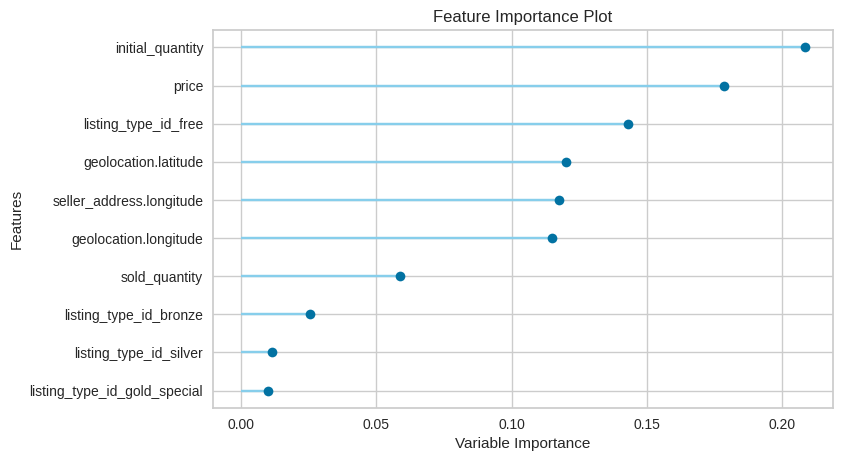

In [ ]:
plot_model(random_forest_classifier, plot = 'feature')

##### **---> Métricas de evaluación:**

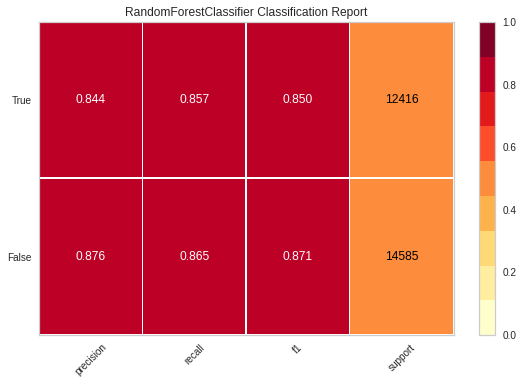

In [ ]:
plot_model(random_forest_classifier, plot = 'class_report')

##### **---> Matriz de confusión:**

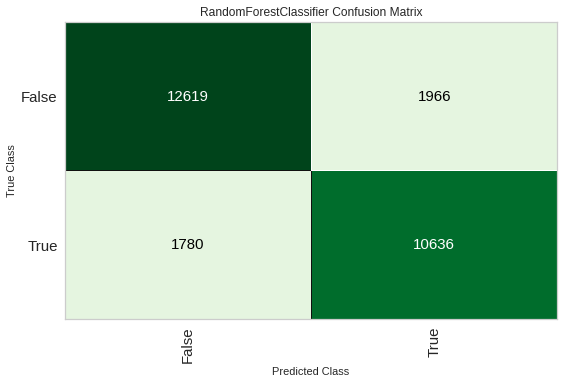

In [ ]:
plot_model(random_forest_classifier, plot = 'confusion_matrix')

##### **---> Curva ROC:**

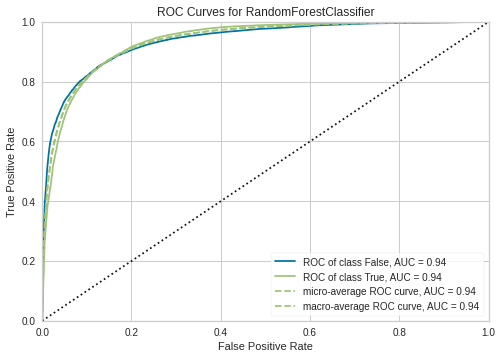

In [ ]:
plot_model(random_forest_classifier, plot = 'auc')

## 09. Evaluación del modelo sobre valores de test

In [ ]:
random_forest_classifier_final = finalize_model(random_forest_classifier)

In [ ]:
df_model_X_test

,accepts_mercadopago,automatic_relist,shipping.local_pick_up,shipping.free_shipping,initial_quantity,available_quantity,sold_quantity,base_price,price,seller_address.longitude,seller_address.latitude,geolocation.latitude,geolocation.longitude,listing_type_id,buying_mode,currency_id,status
0,True,False,True,False,1,1,0,6700.0,6700.0,-58.948750,-34.610683,-34.610683,-58.948750,silver,buy_it_now,ARS,active
1,True,False,False,False,19,19,0,119.0,119.0,-58.381592,-34.603722,-34.603722,-58.381592,bronze,buy_it_now,ARS,active
2,True,False,False,False,2,2,0,450.0,450.0,-58.631729,-34.692066,-34.692066,-58.631729,bronze,buy_it_now,ARS,active
3,True,False,True,False,1,1,0,40.0,40.0,-58.510281,-34.484993,-34.484993,-58.510281,bronze,buy_it_now,ARS,active
4,True,False,True,False,1,1,1,30.0,30.0,-58.425423,-34.582630,-34.582630,-58.425423,bronze,buy_it_now,ARS,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,False,True,False,1,1,0,30.0,30.0,-58.614288,-34.489319,-34.489319,-58.614288,free,buy_it_now,ARS,active
9996,True,False,False,False,5,5,0,239.0,239.0,NaN,NaN,NaN,NaN,bronze,buy_it_now,ARS,active
9997,True,False,False,False,1,1,0,600.0,600.0,-58.624119,-34.646786,-34.646786,-58.624119,bronze,buy_it_now,ARS,active
9998,True,False,True,False,1,1,0,50.0,50.0,-58.402039,-34.610008,-34.610008,-58.402039,bronze,buy_it_now,ARS,active


In [ ]:
matriz_predicciones_test = predict_model(random_forest_classifier_final, data=df_model_X_test, encoded_labels=False)
matriz_predicciones_test.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.875,0.9458,0.8685,0.8607,0.8646,0.7485,0.7485


,accepts_mercadopago,automatic_relist,shipping.local_pick_up,shipping.free_shipping,initial_quantity,available_quantity,sold_quantity,base_price,price,seller_address.longitude,seller_address.latitude,geolocation.latitude,geolocation.longitude,listing_type_id,buying_mode,currency_id,status,target,Label,Score
0,True,False,True,False,1,1,0,6700.0,6700.0,-58.948750,-34.610683,-34.610683,-58.948750,silver,buy_it_now,ARS,active,True,False,0.5075
1,True,False,False,False,19,19,0,119.0,119.0,-58.381592,-34.603722,-34.603722,-58.381592,bronze,buy_it_now,ARS,active,False,False,1.0000
2,True,False,False,False,2,2,0,450.0,450.0,-58.631729,-34.692066,-34.692066,-58.631729,bronze,buy_it_now,ARS,active,False,False,0.8900
3,True,False,True,False,1,1,0,40.0,40.0,-58.510281,-34.484993,-34.484993,-58.510281,bronze,buy_it_now,ARS,active,True,True,0.9800
4,True,False,True,False,1,1,1,30.0,30.0,-58.425423,-34.582630,-34.582630,-58.425423,bronze,buy_it_now,ARS,active,False,False,0.5500


La tabla superior muestra en su encabezado las métricas obtenidas por el modelo sobre el conjunto de test (datos que por supuesto el modelo no vio durante su entrenamiento). En ambos casos, tanto para los valores de entrenamiento como para los de test, las métricas son consistentes y presentan valores superiores al 84%.

## 10. Etapas complementarias contempladas pero no implementadas en el presente alcance: 

 
Por último quería mencionar algunos elementos que aunque no fueron implementados se pueden tener en cuenta como pasos futuros del proyecto:
 
- Desanidación o parsing de los atributos de tipo lista para incluir variables adicionales al análisis y determinar si son útiles para el modelo.
- Generación de variables complementarias a partir de variables ya existentes(ej: cantidades de imágenes, cantidades de artículos vendidos nuevos y viejos por cada vendedor, etc.). 
- Inclusión de la visualización complementaria para EDA de pandas profiling y una descripción mayor del EDA.
- Posibles modelos de NLP que permitan generar características adicionales de clasificación a partir de la descripción de los anuncios.
- Optimización de los hiperparametro del modelo con el fin de mejorar las métricas de clasificación y los tiempos de ejecución.
- Implementación del pipeline del modelo.